# **Skin Cancer Classification**

## **About the Dataset**

Skin cancer is the most common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

This the HAM10000 ("Human Against Machine with 10000 training images") dataset.It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

It has 7 different classes of skin cancer which are listed below :

1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

## **Importing Necessary Libraries**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## **Making Dictionary of Images and Labels**

In [ ]:
base_skin_dir = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
imageid_path_dict

{'ISIC_0028933': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028933.jpg',
 'ISIC_0028394': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028394.jpg',
 'ISIC_0027799': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027799.jpg',
 'ISIC_0028100': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028100.jpg',
 'ISIC_0027960': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027960.jpg',
 'ISIC_0028872': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0028872.jpg',
 'ISIC_0026412': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0026412.jpg',
 'ISIC_0024872': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0024872.jpg',
 'ISIC_0026232': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0026232.jpg',
 'ISIC_0027031': '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027

## **Loading & Processing Dataset**

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


## **Data Cleaning**

In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [ ]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

## **Exploratory Data Analysis**

### ***Distribution of 7 different classes of cell type***

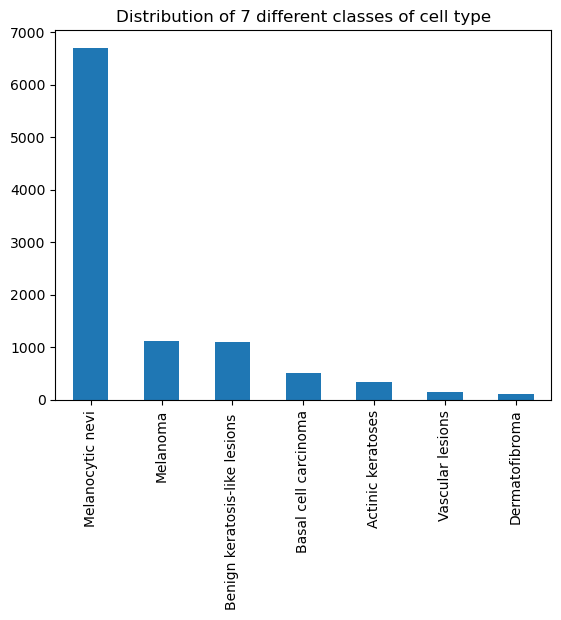

In [ ]:
skin_df['cell_type'].value_counts().plot(kind='bar')
plt.title('Distribution of 7 different classes of cell type')
plt.show()

### ***Distribution of localization field***

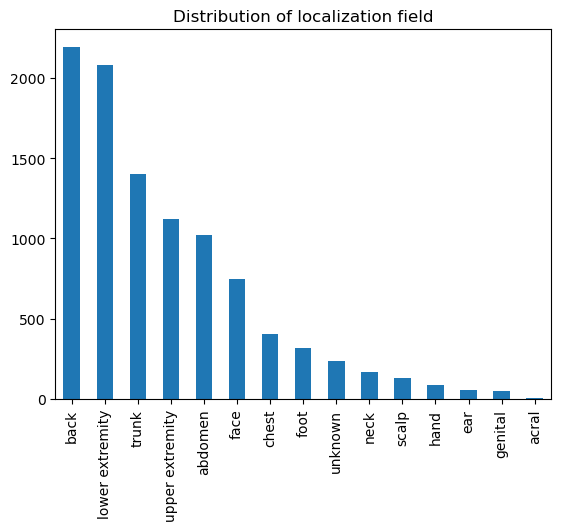

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')
plt.title('Distribution of localization field')
plt.show()

### ***Distribution of Age***

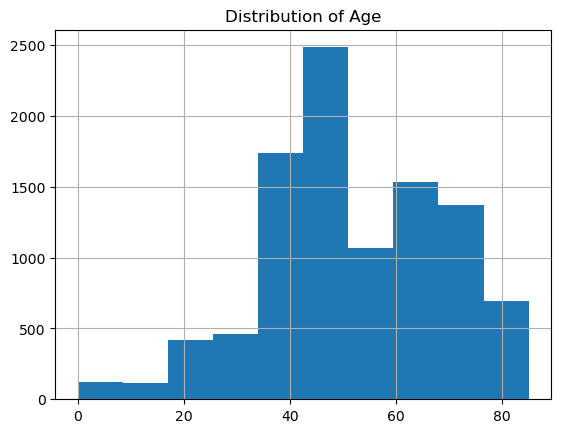

In [ ]:
skin_df['age'].hist()
plt.title('Distribution of Age')
plt.show()

### ***Distribution of males and females***

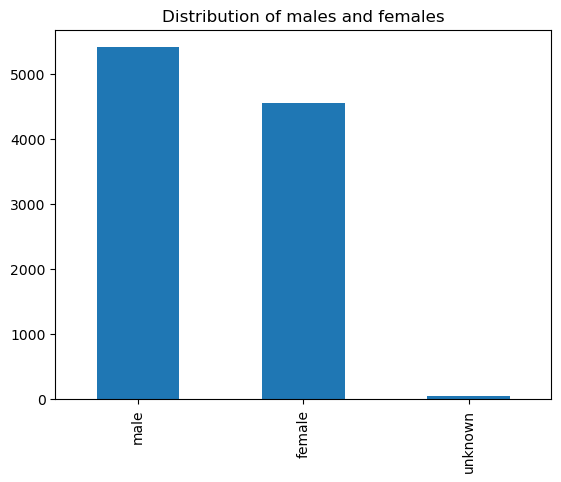

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')
plt.title('Distribution of males and females')
plt.show()

## **Loading and Resizing of images**

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [ ]:
# Saving the DataFrame

skin_df.to_csv('skin_df.csv',index=False)

### ***Visualizing the Images***

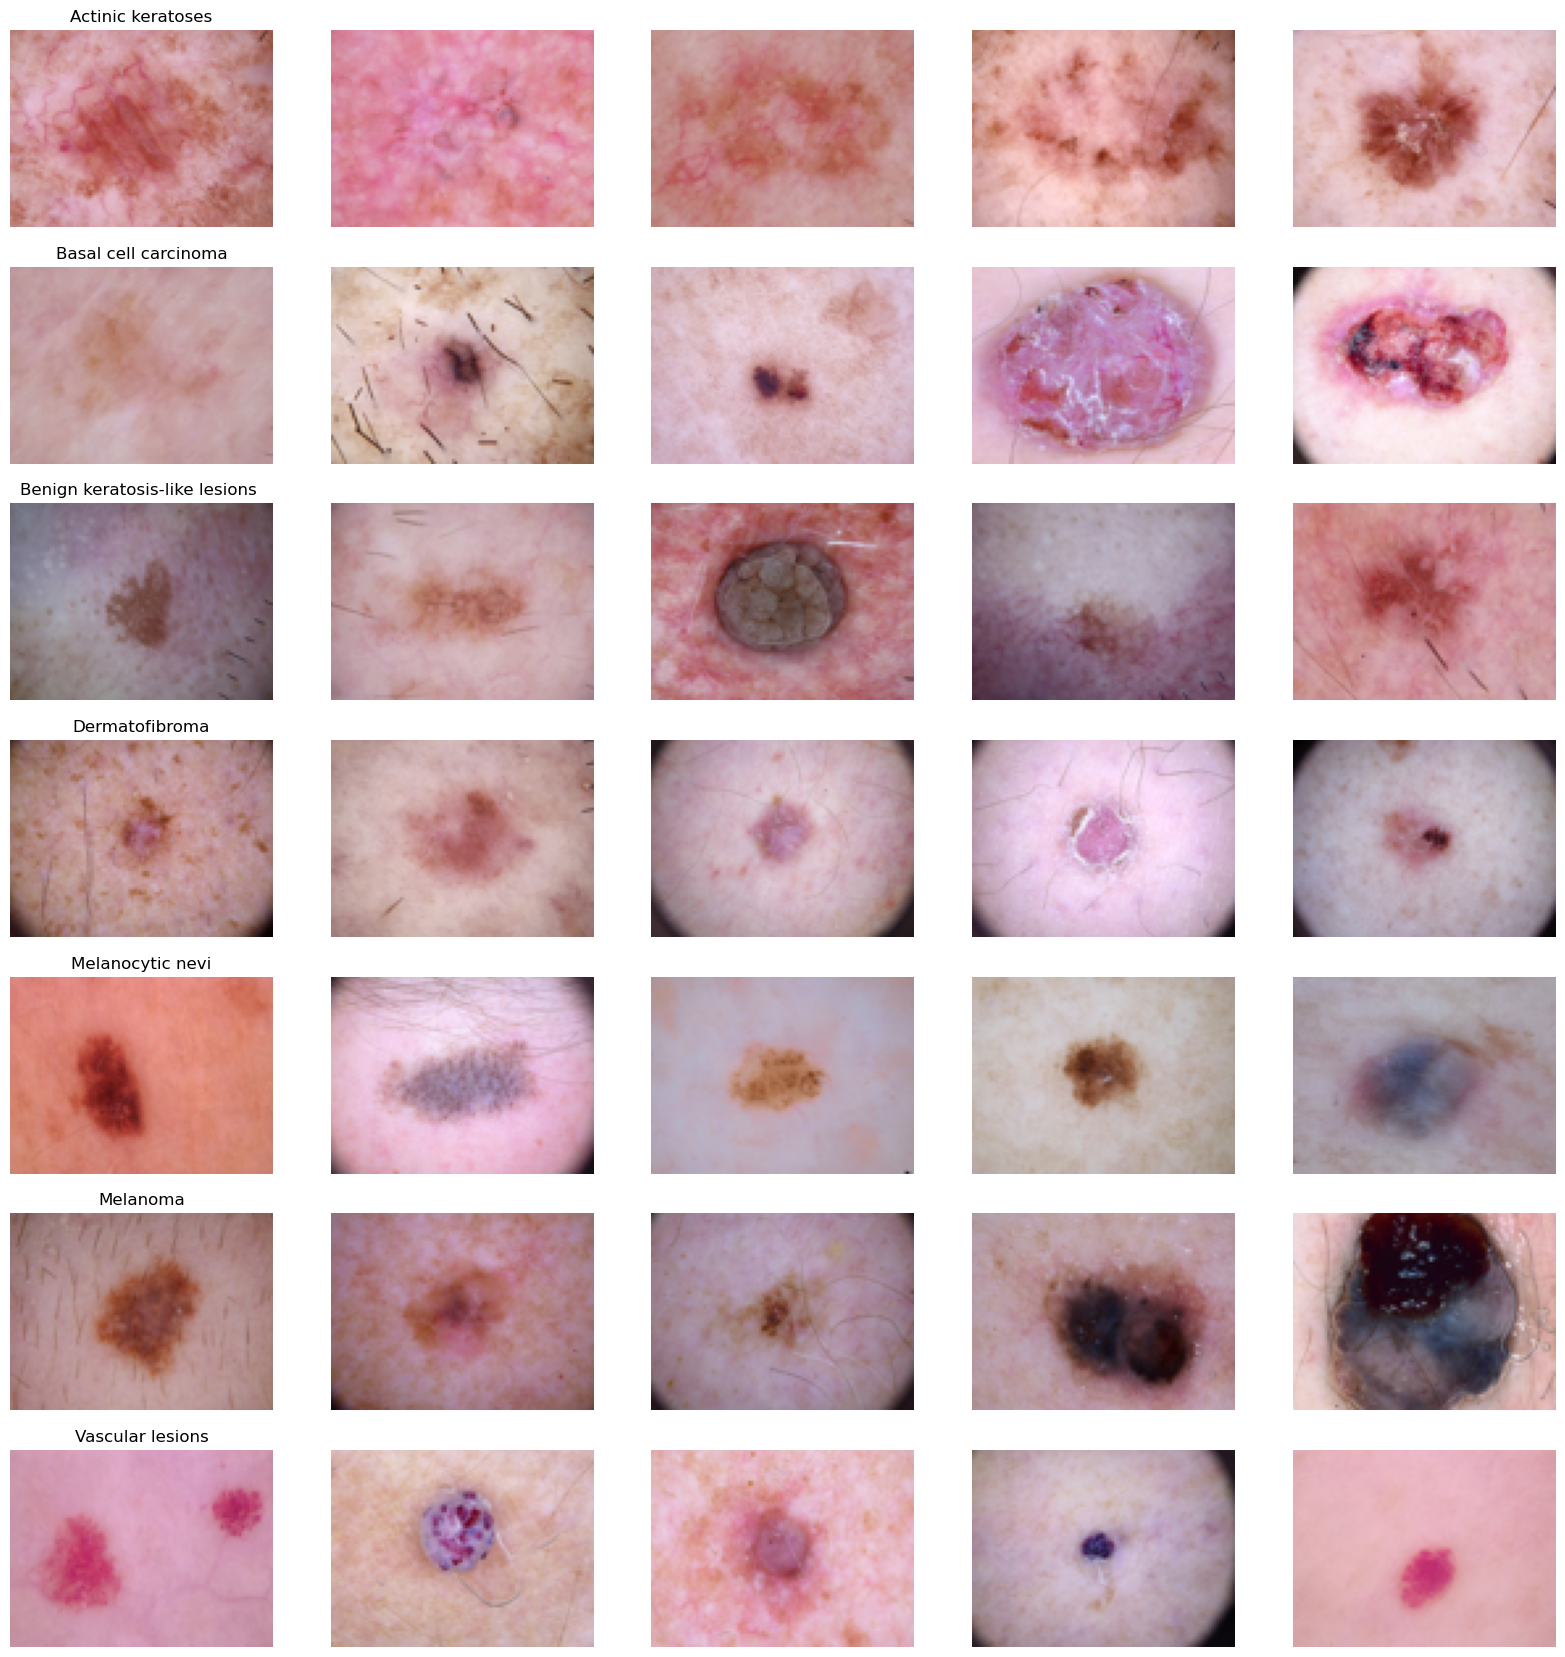

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
# Checking the image shape and it's count

skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

## **Segregating the Dataset into Features(Input) and Targets(Output)**

In [ ]:
skin_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [ ]:
features =  skin_df.drop(columns=['cell_type_idx'],axis=1)
target   =  skin_df['cell_type_idx']

## **Splitting the Dataset into Training and Testing Data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=1234)

In [ ]:
np.asarray(x_train['image'].tolist())[0]

array([[[156, 114, 126],
        [160, 120, 131],
        [164, 125, 135],
        ...,
        [158,  97,  97],
        [152,  90,  88],
        [151,  88,  83]],

       [[159, 117, 128],
        [163, 124, 134],
        [167, 129, 137],
        ...,
        [162, 102,  99],
        [156,  96,  92],
        [155,  95,  92]],

       [[161, 121, 130],
        [165, 128, 135],
        [169, 132, 139],
        ...,
        [161, 100,  95],
        [161,  99,  97],
        [160, 100,  99]],

       ...,

       [[170, 126, 135],
        [173, 126, 136],
        [176, 131, 138],
        ...,
        [185, 147, 154],
        [185, 147, 155],
        [184, 146, 156]],

       [[169, 126, 135],
        [170, 126, 135],
        [175, 131, 139],
        ...,
        [186, 143, 152],
        [182, 140, 150],
        [181, 140, 150]],

       [[169, 127, 135],
        [170, 126, 135],
        [173, 129, 139],
        ...,
        [183, 142, 153],
        [180, 137, 147],
        [178, 137, 146]]

In [ ]:
y_train

8442    4
2908    1
8909    4
58      2
2960    1
       ..
664     2
7540    4
7221    4
1318    5
8915    4
Name: cell_type_idx, Length: 8012, dtype: int8

## **Normalizing the Data**

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
x_train[0]

array([[[-0.08361123, -0.98772191, -0.72940458],
        [ 0.00249455, -0.85856324, -0.62177235],
        [ 0.08860032, -0.75093102, -0.53566657],
        ...,
        [-0.04055834, -1.35367147, -1.35367147],
        [-0.16971701, -1.50435659, -1.54740948],
        [-0.19124346, -1.54740948, -1.6550417 ]],

       [[-0.0190319 , -0.92314258, -0.68635169],
        [ 0.06707388, -0.77245747, -0.55719302],
        [ 0.15317966, -0.66482524, -0.49261368],
        ...,
        [ 0.04554744, -1.24603925, -1.31061858],
        [-0.08361123, -1.37519792, -1.4613037 ],
        [-0.10513768, -1.39672436, -1.4613037 ]],

       [[ 0.02402099, -0.8370368 , -0.6432988 ],
        [ 0.11012677, -0.68635169, -0.53566657],
        [ 0.19623255, -0.60024591, -0.44956079],
        ...,
        [ 0.02402099, -1.28909214, -1.39672436],
        [ 0.02402099, -1.31061858, -1.35367147],
        [ 0.00249455, -1.28909214, -1.31061858]],

       ...,

       [[ 0.21775899, -0.72940458, -0.53566657],
        [ 0

## **Label Encoding**

In [ ]:
# Performing one-hot encoding on the labels

y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [ ]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## **Splitting the Training Dataset into Training and Validation Data**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px,channel = 3)

x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## **Building the Model**

In [ ]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## **Summarizing the Model**

In [ ]:
model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 73, 98, 32)                      896            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 71, 96, 32)                      9248           
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 35, 48, 32)                      0              
                                                                                                    
 dropout (Dropout)                           (None, 35, 48, 32)                      0              
                                                                       

## **Compiling the Model**

In [ ]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

## **Training the Model**

In [ ]:
# Fitting the model

epochs = 50 
batch_size = 10

history = model.fit(x_train,y_train,epochs = epochs, batch_size=batch_size, validation_data = (x_validate,y_validate))

Epoch 1/50


2023-06-11 08:24:14.172344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


721/721 [==============================] - 14s 7ms/step - loss: 0.9870 - accuracy: 0.6667 - val_loss: 0.8924 - val_accuracy: 0.6808
Epoch 2/50
721/721 [==============================] - 4s 6ms/step - loss: 0.8936 - accuracy: 0.6774 - val_loss: 0.8426 - val_accuracy: 0.6858
Epoch 3/50
721/721 [==============================] - 5s 7ms/step - loss: 0.8717 - accuracy: 0.6886 - val_loss: 0.8248 - val_accuracy: 0.7020
Epoch 4/50
721/721 [==============================] - 4s 6ms/step - loss: 0.8367 - accuracy: 0.6994 - val_loss: 0.7912 - val_accuracy: 0.7082
Epoch 5/50
721/721 [==============================] - 4s 6ms/step - loss: 0.7949 - accuracy: 0.7129 - val_loss: 0.7649 - val_accuracy: 0.7120
Epoch 6/50
721/721 [==============================] - 4s 6ms/step - loss: 0.7864 - accuracy: 0.7221 - val_loss: 0.7535 - val_accuracy: 0.7257
Epoch 7/50
721/721 [==============================] - 4s 6ms/step - loss: 0.7371 - accuracy: 0.7308 - val_loss: 0.7392 - val_accuracy: 0.7257
Epoch 8/50
721/7

## **Saving the Model**

In [ ]:
# Saving the Model into the Local Disk

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    model.save_weights("model.h5")
    print("Saved Model to Disk")

Saved Model to Disk


## **Loading the Saved Model**

In [ ]:
# Loading the saved model

from  keras.models import model_from_json

json_file = open("model.json","r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")
print("Model Loaded Successfully")

Model Loaded Successfully


In [ ]:
model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 73, 98, 32)                      896            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 71, 96, 32)                      9248           
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 35, 48, 32)                      0              
                                                                                                    
 dropout (Dropout)                           (None, 35, 48, 32)                      0              
                                                                       

## **Model Evaluation**

In [ ]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation Dataset: accuracy = %f  ;  loss = %f" % (accuracy_v, loss_v))
print("Testing    Dataset: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 0s 5ms/step - loss: 1.5097 - accuracy: 0.7419
Validation Dataset: accuracy = 0.741895  ;  loss = 1.509696
Testing    Dataset: accuracy = 0.745382  ;  loss = 1.548765
